<a href="https://colab.research.google.com/github/toooo-pharma/AI-/blob/main/AI%E5%89%B5%E8%96%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
x = 7
y = 3
print("7+3",x+y)

7+3 10


In [ ]:
for i in range(1,6):
  print("ループ番号:",i)


ループ番号: 1
ループ番号: 2
ループ番号: 3
ループ番号: 4
ループ番号: 5


アスピリン 分子量: 180.15899999999996
アスピリン LogP : 1.3101
                     smiles         name
0  CC(=O)OC1=CC=CC=C1C(=O)O      Aspirin
1        CC1=CC(=O)NC(=O)N1  Paracetamol
2  CC(C)C1=CC=C(C=C1)C(O)=O     Naproxen
                     smiles         name    MolWt     LogP
0  CC(=O)OC1=CC=CC=C1C(=O)O      Aspirin  180.159  1.31010
1        CC1=CC(=O)NC(=O)N1  Paracetamol  126.115 -0.62838
2  CC(C)C1=CC=C(C=C1)C(O)=O     Naproxen  164.204  2.50820
            MolWt      LogP
count    3.000000  3.000000
mean   156.826000  1.063307
std     27.767151  1.582787
min    126.115000 -0.628380
25%    145.159500  0.340860
50%    164.204000  1.310100
75%    172.181500  1.909150
max    180.159000  2.508200


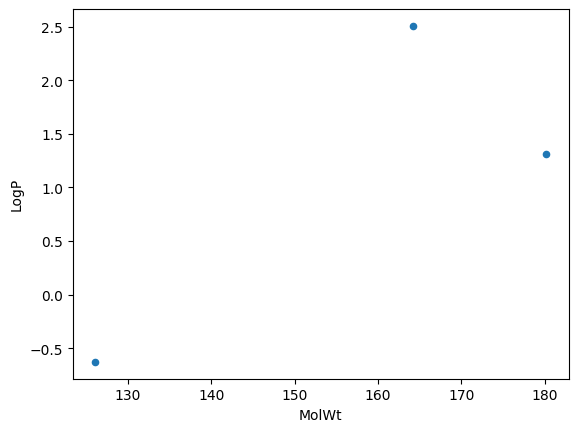

In [ ]:
!pip install rdkit -q

from rdkit import Chem
from rdkit.Chem import Descriptors

smiles_aspirin = "CC(=O)OC1=CC=CC=C1C(=O)O"
mol = Chem.MolFromSmiles(smiles_aspirin)

mw  = Descriptors.MolWt(mol)     # ← W が 大文字
logp = Descriptors.MolLogP(mol)  # ← MolLogP の L も大文字

print("アスピリン 分子量:", mw)
print("アスピリン LogP :", logp)

import pandas as pd

df= pd.read_csv("smiles_list.csv")
print(df.head())

from rdkit import Chem
from rdkit.Chem import Descriptors

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series({"MolWt": None, "LogP": None})
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol)
    })

df_desc = df.join(df["smiles"].apply(smiles_to_descriptors))
print(df_desc)

print(df_desc[["MolWt", "LogP"]].describe())   # 平均・標準偏差
df_desc.plot.scatter(x="MolWt", y="LogP")      # 散布図（関係性ざっくり確認）

assert df_desc["MolWt"].notna().all()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')